In [1]:
import pandas as pd
import gdown
import sqlite3 as sql3

In [2]:
url='https://drive.google.com/file/d/1LCpP0FD-JFwJ0V0k2wbi15Q7s3goGZfa/view?usp=drive_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
gdown.download(url, 'chinook.db', quiet=False)
connection = sql3.connect('chinook.db')

Downloading...
From: https://drive.google.com/uc?id=1LCpP0FD-JFwJ0V0k2wbi15Q7s3goGZfa
To: c:\Users\mail\OneDrive\Documents\my_python\zooming_up\SQL\chinook.db
100%|██████████| 885k/885k [00:00<00:00, 3.32MB/s]


Получаем список таблиц из базы

In [3]:
sql_query = """
            SELECT *
            FROM sqlite_master
            WHERE type = 'table'
            """
cursor = connection.cursor()
cursor.execute(sql_query)
a = cursor.fetchall()
t = []
for i in range(12):
    try:
        t.append(a[i][4].split("\"")[1])
    except IndexError:
        continue
t

['albums',
 'artists',
 'customers',
 'employees',
 'genres',
 'invoices',
 'invoice_items',
 'media_types',
 'playlists',
 'playlist_track',
 'tracks']

JOIN через WHERE

In [65]:
query = """
        SELECT      *

        -- в таблице albums 347 записей, в таблице artists - 275

        FROM        artists, albums

        -- перечислением через запятую мы делаем cross join или декартово произведение  таблиц
        -- порядок не имеет значения - для каждой записи из одной таблицы добавляются все записи из второй и общее число записей получается 95425

        WHERE albums.artistid = artists.artistid

        -- из cross join мы фильтруем только те записи, в которых совпадают ключи и таким образом превращаем cross join в inner join
        """
pd.read_sql_query(query, connection)

,ArtistId,Name,AlbumId,Title,ArtistId
0,1,AC/DC,1,For Those About To Rock We Salute You,1
1,2,Accept,2,Balls to the Wall,2
2,2,Accept,3,Restless and Wild,2
3,1,AC/DC,4,Let There Be Rock,1
4,3,Aerosmith,5,Big Ones,3
...,...,...,...,...,...
342,226,Eugene Ormandy,343,Respighi:Pines of Rome,226
343,272,Emerson String Quartet,344,Schubert: The Late String Quartets & String Qu...,272
344,273,"C. Monteverdi, Nigel Rogers - Chiaroscuro; Lon...",345,Monteverdi: L'Orfeo,273
345,274,Nash Ensemble,346,Mozart: Chamber Music,274


Выбираем только неуникальные значения

In [11]:
query = """
        SELECT      name, count(1) as cnt
        FROM        tracks
        GROUP BY    name
        HAVING      count(1)>1
        ORDER BY    cnt DESC
        LIMIT 3
        """
pd.read_sql_query(query, connection)

,Name,cnt
0,Wrathchild,5
1,The Trooper,5
2,The Number Of The Beast,5


При группировке мы можем вывести только постоянное значение, поле группировки и агрегаты групп, получившихся в результатах группировки

In [17]:
query = """
        SELECT      'test' as literal, composer, sum(UnitPrice) as sum
        FROM        tracks
        GROUP BY    composer 
        ORDER BY    sum DESC
        LIMIT 5
        """
pd.read_sql_query(query, connection)

,literal,Composer,sum
0,test,None,1181.22
1,test,Steve Harris,79.20
2,test,U2,43.56
3,test,Jagger/Richards,34.65
4,test,Billy Corgan,30.69


Порядок выполнения, последним заполняем SELECT

In [ ]:
query = """
        SELECT      
        FROM
            JOIN
        WHERE        
        GROUP BY
        HAVING    
        ORDER BY    
        LIMIT
        """

Выбор колонок для отображения после джойна

In [82]:
query = """
        SELECT      albums.*, artists.name
        FROM        albums
                LEFT JOIN   artists
                ON albums.ArtistId = artists.artistid
        """
pd.read_sql_query(query, connection)

,AlbumId,Title,ArtistId,Name
0,1,For Those About To Rock We Salute You,1,AC/DC
1,2,Balls to the Wall,2,Accept
2,3,Restless and Wild,2,Accept
3,4,Let There Be Rock,1,AC/DC
4,5,Big Ones,3,Aerosmith
...,...,...,...,...
342,343,Respighi:Pines of Rome,226,Eugene Ormandy
343,344,Schubert: The Late String Quartets & String Qu...,272,Emerson String Quartet
344,345,Monteverdi: L'Orfeo,273,"C. Monteverdi, Nigel Rogers - Chiaroscuro; Lon..."
345,346,Mozart: Chamber Music,274,Nash Ensemble


Скалярный запрос - число для фильтрации через WHERE. То есть, в подзапросе мы вычисляем значение (агрегат), которое используем в запросе.

Главное, чтобы получалось одно значение.

МАКС и МИН значения из другого источника получаем через ORDER BY и LIMIT 1

In [92]:
query = """
        SELECT      *
        FROM        tracks
        WHERE unitprice = (SELECT max(unitprice)
                           FROM tracks)        
        
        """
pd.read_sql_query(query, connection)

,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
0,2819,Battlestar Galactica: The Story So Far,226,3,18,None,2622250,490750393,1.99
1,2820,Occupation / Precipice,227,3,19,None,5286953,1054423946,1.99
2,2821,"Exodus, Pt. 1",227,3,19,None,2621708,475079441,1.99
3,2822,"Exodus, Pt. 2",227,3,19,None,2618000,466820021,1.99
4,2823,Collaborators,227,3,19,None,2626626,483484911,1.99
...,...,...,...,...,...,...,...,...,...
208,3362,"There's No Place Like Home, Pt. 1",261,3,21,None,2609526,522919189,1.99
209,3363,"There's No Place Like Home, Pt. 2",261,3,21,None,2497956,523748920,1.99
210,3364,"There's No Place Like Home, Pt. 3",261,3,21,None,2582957,486161766,1.99
211,3428,Branch Closing,251,3,22,None,1814855,360331351,1.99


ALL нет в SQL, но он заменяется, больше каждого - больше максимального, меньше каждого - меньше минимального  и т.д.

ALL - каждый в списке, сформированном подзаросом, соответствует условию

IN - значение входит в список, сформированный условием подзапроса

ANY - где хотя бы один элемент соответствует условию

In [110]:
query = """
        SELECT  name
        FROM    tracks
        WHERE   unitprice IN (SELECT max(unitprice) FROM tracks)
        """
pd.read_sql_query(query, connection)

,Name
0,Battlestar Galactica: The Story So Far
1,Occupation / Precipice
2,"Exodus, Pt. 1"
3,"Exodus, Pt. 2"
4,Collaborators
...,...
208,"There's No Place Like Home, Pt. 1"
209,"There's No Place Like Home, Pt. 2"
210,"There's No Place Like Home, Pt. 3"
211,Branch Closing


Двухстолбцовое сравнение

In [118]:
query = """
        SELECT  *
        FROM    tracks
        WHERE   (trackid, unitprice) IN (SELECT trackid, unitprice FROM invoice_items)
        
        """
pd.read_sql_query(query, connection)

,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
0,1,For Those About To Rock (We Salute You),1,1,1,"Angus Young, Malcolm Young, Brian Johnson",343719,11170334,0.99
1,2,Balls to the Wall,2,2,1,None,342562,5510424,0.99
2,3,Fast As a Shark,3,2,1,"F. Baltes, S. Kaufman, U. Dirkscneider & W. Ho...",230619,3990994,0.99
3,4,Restless and Wild,3,2,1,"F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. D...",252051,4331779,0.99
4,5,Princess of the Dawn,3,2,1,Deaffy & R.A. Smith-Diesel,375418,6290521,0.99
...,...,...,...,...,...,...,...,...,...
1979,3493,"Metopes, Op. 29: Calypso",337,2,24,Karol Szymanowski,333669,5548755,0.99
1980,3494,"Symphony No. 2, Op. 16 - ""The Four Temperamen...",338,2,24,Carl Nielsen,286998,4834785,0.99
1981,3496,"Étude 1, In C Major - Preludio (Presto) - Liszt",340,4,24,None,51780,2229617,0.99
1982,3499,Pini Di Roma (Pinien Von Rom) \ I Pini Della V...,343,2,24,None,286741,4718950,0.99


Забираем данные из другой таблицы через ДЖОЙН

In [139]:
query = """
        SELECT  artists.name, count(1) as cnt                
        FROM    albums
                LEFT JOIN artists
                ON artists.artistid = albums.artistid
        GROUP BY artists.name
        ORDER BY cnt DESC 
        """
pd.read_sql_query(query, connection)

,Name,cnt
0,Iron Maiden,21
1,Led Zeppelin,14
2,Deep Purple,11
3,U2,10
4,Metallica,10
...,...,...
199,"Academy of St. Martin in the Fields, John Birc...",1
200,Academy of St. Martin in the Fields Chamber En...,1
201,Academy of St. Martin in the Fields & Sir Nevi...,1
202,Aaron Goldberg,1


Забираем данные из другой таблицы через кореллированный подзапрос

In [4]:
query = """
        SELECT  name,
                (SELECT COUNT(1)
                FROM albums
                GROUP BY ArtistId
                HAVING albums.artistid = artists.artistid
                ) as cnt
        FROM    artists
        ORDER BY cnt DESC        
        """
pd.read_sql_query(query, connection)

,Name,cnt
0,Iron Maiden,21.0
1,Led Zeppelin,14.0
2,Deep Purple,11.0
3,Metallica,10.0
4,U2,10.0
...,...,...
270,DJ Dolores & Orchestra Santa Massa,NaN
271,Seu Jorge,NaN
272,Sabotage E Instituto,NaN
273,Stereo Maracana,NaN


In [ ]:
query = """
        SELECT  *
        FROM    albums       
        """
pd.read_sql_query(query, connection)

CTE - промежуточная таблица, собираемая один раз в рамках запроса

In [26]:
query = """
        WITH    U2 (id, album, artist) AS
                (SELECT *
                FROM albums
                WHERE artistid = 
                        (SELECT artistid
                        FROM artists
                        WHERE name = 'U2')
                )

       ,        Metallica AS
                (SELECT *
                FROM albums
                WHERE artistid = 
                        (SELECT artistid
                        FROM artists
                        WHERE name = 'Metallica')
                        )


        SELECT *
        FROM U2

        UNION ALL

        SELECT *
        FROM Metallica
        """
pd.read_sql_query(query, connection)

,id,album,artist
0,232,Achtung Baby,150
1,233,All That You Can't Leave Behind,150
2,234,B-Sides 1980-1990,150
3,235,How To Dismantle An Atomic Bomb,150
4,236,Pop,150
5,237,Rattle And Hum,150
6,238,The Best Of 1980-1990,150
7,239,War,150
8,240,Zooropa,150
9,255,Instant Karma: The Amnesty International Campa...,150


UNION, INTERSECT, EXCEPT

In [40]:
query = """
        SELECT  ArtistId, title
        FROM    albums
        
    INTERSECT

        SELECT  *
        FROM    artists
    
        """
pd.read_sql_query(query, connection)

,ArtistId,Title
0,8,Audioslave
1,12,Black Sabbath
2,13,Body Count
3,90,Iron Maiden
4,112,Olodum
5,118,Pearl Jam
6,126,Raul Seixas
7,140,The Doors
8,152,Van Halen
9,159,Aquaman


CASE - WHEN - THEN - ELSE - END

In [46]:
query = """
        SELECT   CASE 
                    WHEN UnitPrice = 0.99 THEN 'cheap'
                    WHEN UnitPrice = 1.99 THEN 'expensive'
                 END as flag,
                 COUNT (1) as cnt

        FROM     tracks
        GROUP BY flag
    
        """
pd.read_sql_query(query, connection)

,flag,cnt
0,cheap,3290
1,expensive,213


IF (IIF)

In [50]:
query = """
        SELECT  IIF(UnitPrice = 0.99,'cheap', 'expensive') as flag,
                 COUNT (1) as cnt

        FROM     tracks
        GROUP BY flag
    
        """
pd.read_sql_query(query, connection)

,flag,cnt
0,cheap,3290
1,expensive,213


Оконные функции 

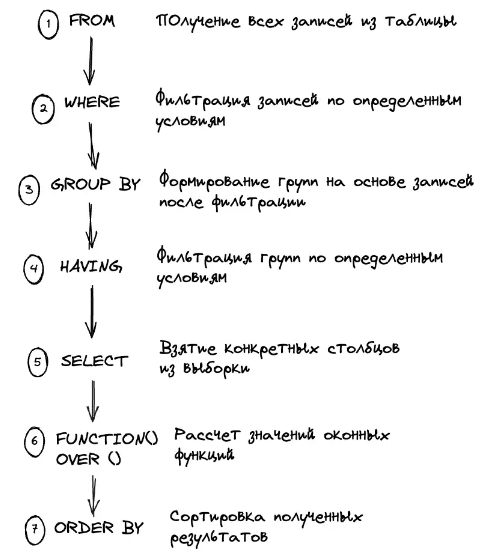

Агрегат по колонке всей таблицы схлопывает таблицу

In [120]:
query = """
        WITH cte AS
        (SELECT  invoice_items.quantity as qty, tracks.name as track, albums.title as album
        FROM    invoice_items
                LEFT JOIN tracks
                ON tracks.trackid = invoice_items.trackid
                LEFt JOIN albums
                ON albums.AlbumId= tracks.AlbumId)

        SELECT *, COUNT(1) as cnt
        FROM cte
        LIMIT 3
        """
pd.read_sql_query(query, connection)

,qty,track,album,cnt
0,1,Balls to the Wall,Balls to the Wall,2240


Агрегат, вынесенный в подзапрос, передается как константа в каждую запись

In [123]:
query = """
        WITH cte AS
        (SELECT  invoice_items.quantity as qty, tracks.name as track, albums.title as album
        FROM    invoice_items
                LEFT JOIN tracks
                ON tracks.trackid = invoice_items.trackid
                LEFt JOIN albums
                ON albums.AlbumId= tracks.AlbumId)

        SELECT *, 
                (SELECT count(qty)
                FROM cte) as avg
        FROM cte
        LIMIT 3
        """
pd.read_sql_query(query, connection)

,qty,track,album,avg
0,1,Balls to the Wall,Balls to the Wall,2240
1,1,Restless and Wild,Restless and Wild,2240
2,1,Put The Finger On You,For Those About To Rock We Salute You,2240


OVER() - агрегат над всей таблицей - так же передается как константа в каждую запись

In [133]:
query = """
        WITH cte AS
        (SELECT  invoice_items.quantity as qty, tracks.name as track, albums.title as album
        FROM    invoice_items
                LEFT JOIN tracks
                ON tracks.trackid = invoice_items.trackid
                LEFt JOIN albums
                ON albums.AlbumId= tracks.AlbumId)

        SELECT *, COUNT(1)
        OVER () as cnt
        FROM cte
        LIMIT 3
        """
pd.read_sql_query(query, connection)

,qty,track,album,cnt
0,1,Balls to the Wall,Balls to the Wall,2240
1,1,Restless and Wild,Restless and Wild,2240
2,1,Put The Finger On You,For Those About To Rock We Salute You,2240


Агрегация по группировке в столбце, схлопывает группы в запись и добавляет поле со значениями новых записей (схлопнутых групп)

In [129]:
query = """
        WITH cte AS
        (SELECT  invoice_items.quantity as qty, tracks.name as track, albums.title as album
        FROM    invoice_items
                LEFT JOIN tracks
                ON tracks.trackid = invoice_items.trackid
                LEFt JOIN albums
                ON albums.AlbumId= tracks.AlbumId)

        SELECT *, COUNT(1) as cnt
        FROM cte
        GROUP BY album
        ORDER BY cnt DESC
        LIMIT 3
                """
pd.read_sql_query(query, connection)

,qty,track,album,cnt
0,1,"Bye, Bye Brasil",Minha Historia,27
1,1,Are You Gonna Go My Way,Greatest Hits,26
2,1,Tears In Heaven,Unplugged,25


OVER (PARTITION BY) считает тоже самое что и GROUP BY, но не схлопывает записи в группу, а вписывает в каждую запись агрегат для группы

In [132]:
query = """
        WITH cte AS
        (SELECT  invoice_items.quantity as qty, tracks.name as track, albums.title as album
        FROM    invoice_items
                LEFT JOIN tracks
                ON tracks.trackid = invoice_items.trackid
                LEFt JOIN albums
                ON albums.AlbumId= tracks.AlbumId)

        SELECT *, COUNT(1)
        OVER (PARTITION BY album) as cnt
        FROM cte
        ORDER BY cnt DESC
        LIMIT 3
        """
pd.read_sql_query(query, connection)

,qty,track,album,cnt
0,1,"Bye, Bye Brasil",Minha Historia,27
1,1,Atras Da Porta,Minha Historia,27
2,1,Tatuagem,Minha Historia,27


Добавялем сортировку по названию трека и без указания range по умолчанию считается RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
то есть числотреков считается не все для всего альбома, а от начала альбома до конкретной композиции, то есть кумулятивный счетчик
и для композиции с самой далекой от "а" первой буквой получается максимальный cnt. И так для каждого аольбома

In [146]:
query = """
        WITH cte AS
        (SELECT  invoice_items.quantity as qty, tracks.name as track, albums.title as album
        FROM    invoice_items
                LEFT JOIN tracks
                ON tracks.trackid = invoice_items.trackid
                LEFt JOIN albums
                ON albums.AlbumId= tracks.AlbumId)

        SELECT *, COUNT(1)
        OVER (PARTITION BY album
              ORDER BY track ) as cnt
        FROM cte
        ORDER BY cnt DESC
        LIMIT 5
    
        """
pd.read_sql_query(query, connection)

,qty,track,album,cnt
0,1,Voce Nao Entende Nada - Cotidiano,Minha Historia,27
1,1,You're Gonna Break My Hart Again,Greatest Hits,26
2,1,Vai Passar,Minha Historia,26
3,1,Wanted Dread And Alive,Greatest Hits,25
4,1,Um Indio,Minha Historia,25


Если же задать размеры диапазона RANGE BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING, то есть всю партицию, то и cnt для каждой строки будет считаться по всей партиции

In [149]:
query = """
        WITH cte AS
        (SELECT  invoice_items.quantity as qty, tracks.name as track, albums.title as album
        FROM    invoice_items
                LEFT JOIN tracks
                ON tracks.trackid = invoice_items.trackid
                LEFt JOIN albums
                ON albums.AlbumId= tracks.AlbumId)

        SELECT *, COUNT(1)
        OVER (PARTITION BY album
              ORDER BY track
              RANGE BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as cnt
        FROM cte
        ORDER BY cnt DESC
        LIMIT 3
    
        """
pd.read_sql_query(query, connection)

,qty,track,album,cnt
0,1,A Banda,Minha Historia,27
1,1,Apesar De Você,Minha Historia,27
2,1,Atras Da Porta,Minha Historia,27


RANGE - определяется значением, которое формирует партицию. Все треки альбома входят в один range, и потому для всех считается одно и тоже значение

In [155]:
query = """
        WITH cte AS
        (SELECT  invoice_items.quantity as qty, tracks.name as track, albums.title as album
        FROM    invoice_items
                LEFT JOIN tracks
                ON tracks.trackid = invoice_items.trackid
                LEFt JOIN albums
                ON albums.AlbumId= tracks.AlbumId)

        SELECT *, COUNT(1)
        OVER (PARTITION BY album
              ORDER BY album
              RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as cnt
        FROM cte
        ORDER BY cnt DESC
        LIMIT 10
    
        """
pd.read_sql_query(query, connection)

,qty,track,album,cnt
0,1,"Bye, Bye Brasil",Minha Historia,27
1,1,Atras Da Porta,Minha Historia,27
2,1,Tatuagem,Minha Historia,27
3,1,Morena De Angola,Minha Historia,27
4,1,A Banda,Minha Historia,27
5,1,Com Açúcar E Com Afeto,Minha Historia,27
6,1,Meu Caro Amigo,Minha Historia,27
7,1,Trocando Em Miúdos,Minha Historia,27
8,1,Gota D'água,Minha Historia,27
9,1,Podres Poderes,Minha Historia,27


ROWS определяет строки до или после текущей, и для каждого трека альбома внутри партиции считается разный результат

In [157]:
query = """
        WITH cte AS
        (SELECT  invoice_items.quantity as qty, tracks.name as track, albums.title as album
        FROM    invoice_items
                LEFT JOIN tracks
                ON tracks.trackid = invoice_items.trackid
                LEFt JOIN albums
                ON albums.AlbumId= tracks.AlbumId)

        SELECT *, COUNT(1)
        OVER (PARTITION BY album
              ORDER BY album
              ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as cnt
        FROM cte
        ORDER BY cnt DESC
        LIMIT 10
    
        """
pd.read_sql_query(query, connection)

,qty,track,album,cnt
0,1,Menino Do Rio,Minha Historia,27
1,1,Sweet Lady Luck,Greatest Hits,26
2,1,Geni E O Zepelim,Minha Historia,26
3,1,Looking For Love,Greatest Hits,25
4,1,Apesar De Você,Minha Historia,25
5,1,Toda Menina Baiana,Unplugged,25
6,1,If You Don't Know Me By Now,Greatest Hits,24
7,1,Samba De Orly,Minha Historia,24
8,1,Tempo Rei,Unplugged,24
9,1,Pick Myself Up,Greatest Hits,23


Агрегатные оконные функции SUM COUNT MIN MAX AVG

In [181]:
query = """

        SELECT  date(InvoiceDate) as date,
                weeknum,
                Total, 
                COUNT(Total) OVER (PARTITION BY weeknum ORDER BY InvoiceDate RANGE BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as cnt,
                MIN(Total) OVER (PARTITION BY weeknum ORDER BY InvoiceDate RANGE BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as MIN,
                MAX(Total) OVER (PARTITION BY weeknum ORDER BY InvoiceDate RANGE BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as MAX,
                SUM(Total) OVER (PARTITION BY weeknum ORDER BY InvoiceDate RANGE BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as SUM,
                AVG(Total) OVER (PARTITION BY weeknum ORDER BY InvoiceDate RANGE BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as AVG
        FROM 
            (SELECT InvoiceDate,
                    strftime('%W', InvoiceDate) as weeknum,
                    Total
            FROM invoices)
        -- ORDER BY cnt DESC
        LIMIT 10
    
        """
pd.read_sql_query(query, connection)

,date,weeknum,Total,cnt,MIN,MAX,SUM,AVG
0,2009-01-01,00,1.98,6,0.99,13.86,35.64,5.940000
1,2009-01-02,00,3.96,6,0.99,13.86,35.64,5.940000
2,2009-01-03,00,5.94,6,0.99,13.86,35.64,5.940000
3,2011-01-02,00,0.99,6,0.99,13.86,35.64,5.940000
4,2012-01-01,00,13.86,6,0.99,13.86,35.64,5.940000
5,2013-01-02,00,8.91,6,0.99,13.86,35.64,5.940000
6,2009-01-06,01,8.91,7,1.98,13.86,51.49,7.355714
7,2009-01-11,01,13.86,7,1.98,13.86,51.49,7.355714
8,2010-01-08,01,1.98,7,1.98,13.86,51.49,7.355714
9,2010-01-08,01,1.98,7,1.98,13.86,51.49,7.355714


Ранговые функции: ROW_NUMBER, RANK, DENSE_RANK

In [185]:
query = """
        SELECT  date(InvoiceDate) as date,
                weeknum,
                Total, 
                ROW_NUMBER() OVER (PARTITION BY weeknum ORDER BY total RANGE BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as rnum,
                RANK() OVER (PARTITION BY weeknum ORDER BY total RANGE BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as rank,
                DENSE_RANK() OVER (PARTITION BY weeknum ORDER BY total RANGE BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as drank
                FROM 
            (SELECT InvoiceDate,
                    strftime('%W', InvoiceDate) as weeknum,
                    Total
            FROM invoices)
        -- ORDER BY cnt DESC
        LIMIT 10
    
        """
pd.read_sql_query(query, connection)

,date,weeknum,Total,rnum,rank,drank
0,2011-01-02,00,0.99,1,1,1
1,2009-01-01,00,1.98,2,2,2
2,2009-01-02,00,3.96,3,3,3
3,2009-01-03,00,5.94,4,4,4
4,2013-01-02,00,8.91,5,5,5
5,2012-01-01,00,13.86,6,6,6
6,2010-01-08,01,1.98,1,1,1
7,2010-01-08,01,1.98,2,1,1
8,2010-01-09,01,3.96,3,3,2
9,2010-01-10,01,6.94,4,4,3


Функции смещения : LAG, LEAD, FIRST_VALUE, LAST_VALUE

In [190]:
query = """
        SELECT  date(InvoiceDate) as date,
                weeknum,
                Total, 
                LAG(total) OVER (PARTITION BY weeknum ORDER BY total RANGE BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as lag,
                LEAD(total) OVER (PARTITION BY weeknum ORDER BY total RANGE BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as lead,
                FIRST_VALUE(total) OVER (PARTITION BY weeknum ORDER BY total RANGE BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as first,
                LAST_VALUE(total) OVER (PARTITION BY weeknum ORDER BY total RANGE BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as last
                FROM 
            (SELECT InvoiceDate,
                    strftime('%W', InvoiceDate) as weeknum,
                    Total
            FROM invoices)
        -- ORDER BY cnt DESC
        LIMIT 10
    
        """
pd.read_sql_query(query, connection)

,date,weeknum,Total,lag,lead,first,last
0,2011-01-02,00,0.99,NaN,1.98,0.99,13.86
1,2009-01-01,00,1.98,0.99,3.96,0.99,13.86
2,2009-01-02,00,3.96,1.98,5.94,0.99,13.86
3,2009-01-03,00,5.94,3.96,8.91,0.99,13.86
4,2013-01-02,00,8.91,5.94,13.86,0.99,13.86
5,2012-01-01,00,13.86,8.91,NaN,0.99,13.86
6,2010-01-08,01,1.98,NaN,1.98,1.98,13.86
7,2010-01-08,01,1.98,1.98,3.96,1.98,13.86
8,2010-01-09,01,3.96,1.98,6.94,1.98,13.86
9,2010-01-10,01,6.94,3.96,8.91,1.98,13.86
